# Field Data Visualization (4x3)

- Col 1: Original field data
- Col 2: Network output (high-resolution result)
- Col 3: Normalized amplitude spectrum (radial 2D FFT, 0~60 Hz)

Rows: `kus2`, `lulia`, `tp`, `marmousi_20Hz` (spectrum is skipped for marmousi row).


Selected pairs:
- kus2
  original: /home/llp/data/Resolution/seismicSuperResolutionData/field/kus2_608x320.dat
  predict : /home/llp/data/Resolution/seismic_liif/checkpoint/lijintao/liif/results-field/kus2_1216x640_direct.dat
- lulia
  original: /home/llp/data/Resolution/seismicSuperResolutionData/field/lulia_592x400.dat
  predict : /home/llp/data/Resolution/seismic_liif/checkpoint/lijintao/liif/results-field/lulia_1184x800_direct.dat
- tp
  original: /home/llp/data/Resolution/seismicSuperResolutionData/field/tp_352x240.dat
  predict : /home/llp/data/Resolution/seismic_liif/checkpoint/lijintao/liif/results-field/tp_704x480_direct.dat
- marmousi_20Hz
  original: /home/llp/data/Resolution/seismicSuperResolutionData/field/marmousi_20Hz.mat
  predict : /home/llp/data/Resolution/SSL-Resolution-Enhancement/scripts/test_marmousi/output/epoch150/marmousi_20Hz_out.mat


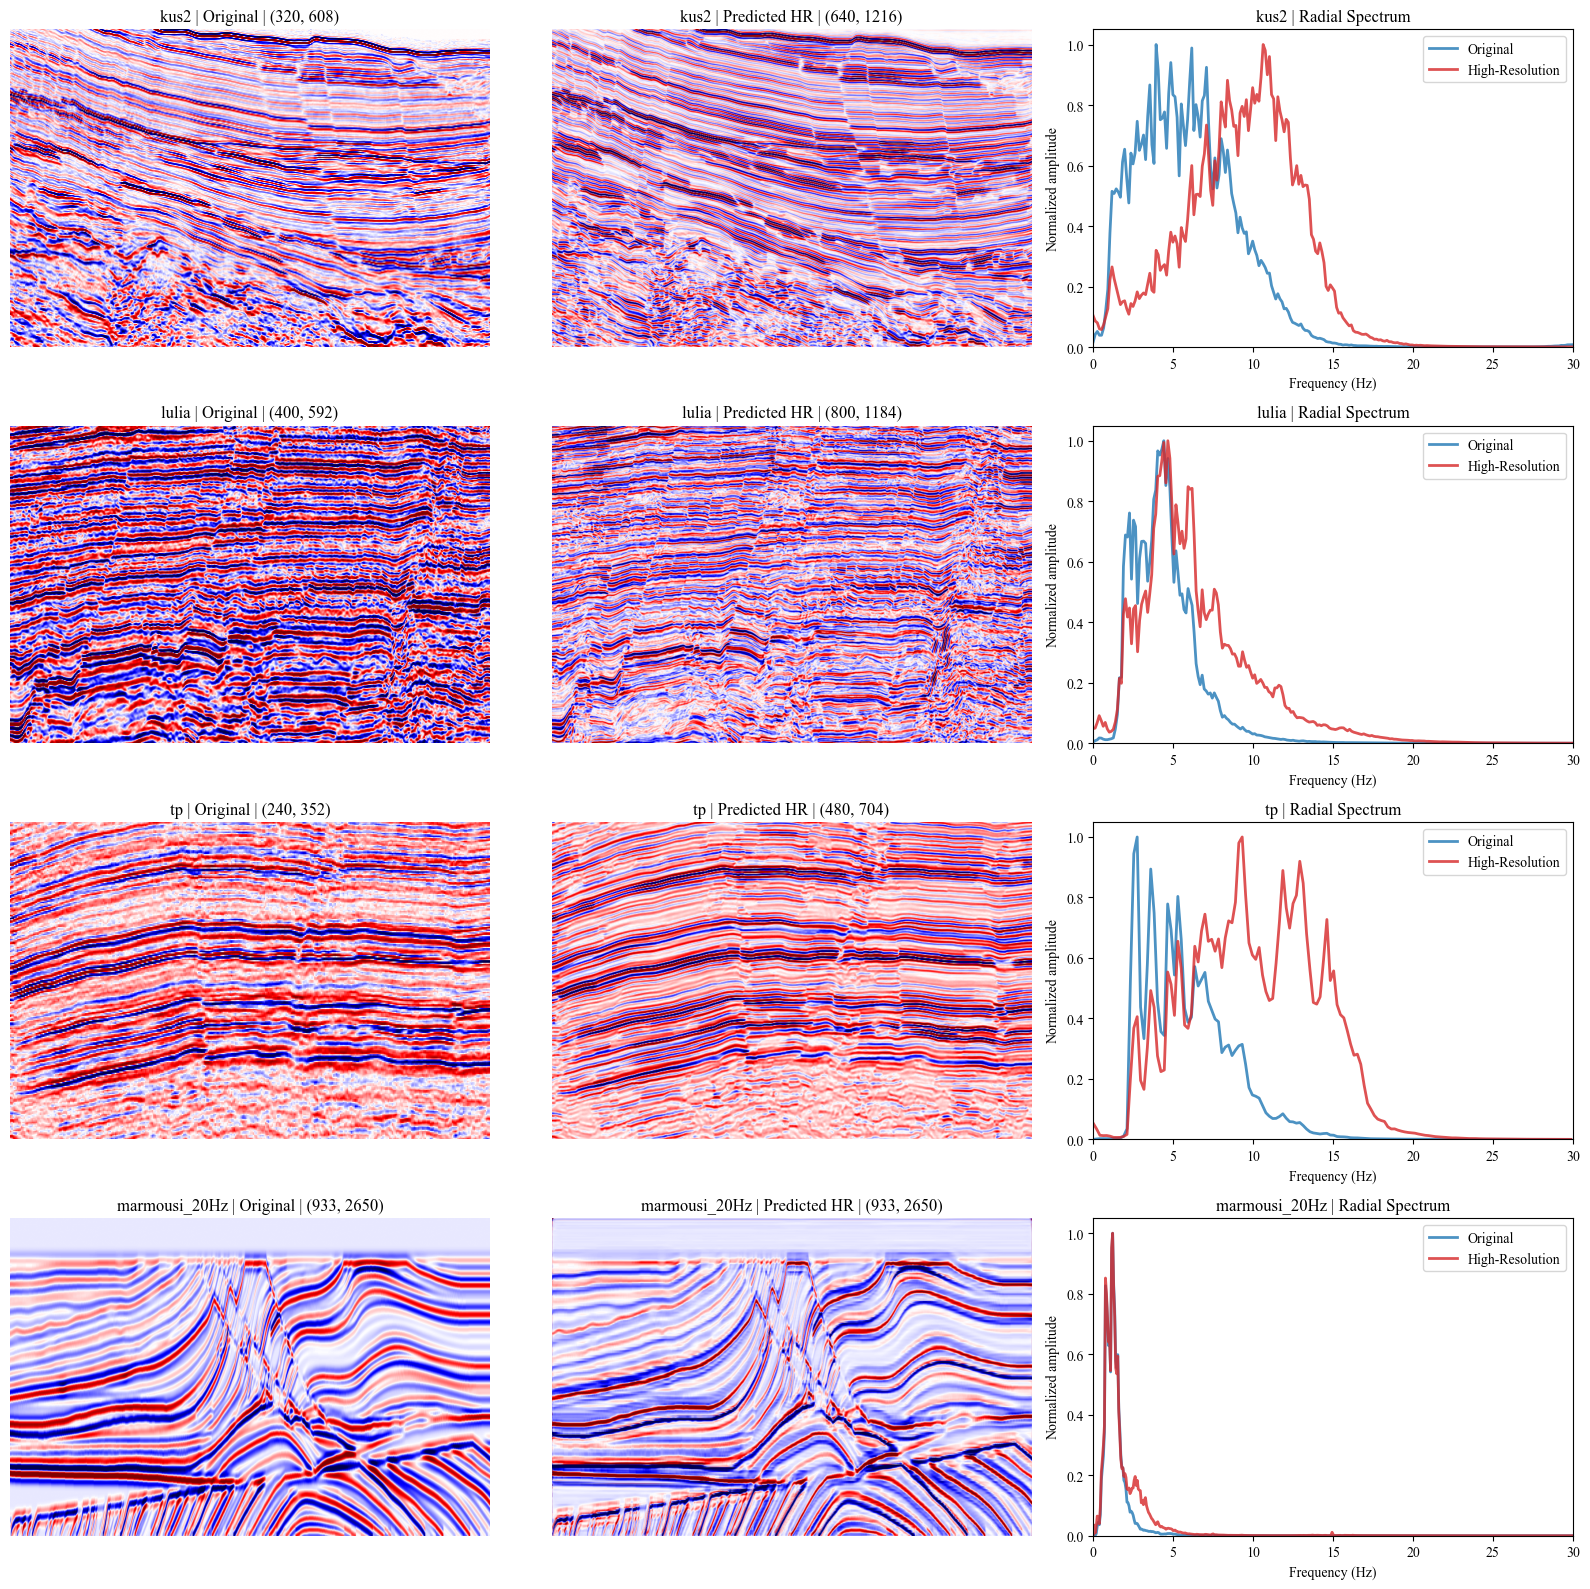

In [4]:

from pathlib import Path
import re
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams["font.family"] = "Times New Roman"

ROOT = Path('/home/llp/data/Resolution/SeismicDiffusion_Resolution')
FIELD_DIR = Path('/home/llp/data/Resolution/seismicSuperResolutionData/field')

# Frequency axis settings
SAMPLE_RATE_HZ = 180.0
FREQ_MAX_HZ = 30.0

# Candidate locations of processed outputs (searched in order)
PRED_DIRS = [
    ROOT / 'runs' / 'field_samples',
    ROOT / 'runs' / 'samples_field',
    ROOT / 'runs' / 'samples',
    Path('/home/llp/data/Resolution/seismic_liif/checkpoint/lijintao/liif/results-field'),
    Path('/home/llp/data/Resolution/seismic_liif/checkpoint/lijintao/alpha6_unet/results-field'),
    Path('/home/llp/data/Resolution/seismic_liif/checkpoint/lijintao/liif_no/results-field'),
    Path('/home/llp/data/Resolution/seismic_liif/checkpoint/lijintao/liif_no_small/results-field'),
    Path('/home/llp/data/Resolution/SeismicSuperResolution/experiment/alpha6/results-field'),
    Path('/home/llp/data/Resolution/SSL-Resolution-Enhancement/scripts/test/output/epoch400'),
    Path('/home/llp/data/Resolution/SSL-Resolution-Enhancement/scripts/test_marmousi/output/epoch150'),
]

ROWS = [
    {
        'label': 'kus2',
        'orig_path': FIELD_DIR / 'kus2_608x320.dat',
        'aliases': ['kus2', 'kumano2'],
        'plot_spectrum': True,
        'transpose_display': True,
    },
    {
        'label': 'lulia',
        'orig_path': FIELD_DIR / 'lulia_592x400.dat',
        'aliases': ['lulia'],
        'plot_spectrum': True,
        'transpose_display': True,
    },
    {
        'label': 'tp',
        'orig_path': FIELD_DIR / 'tp_352x240.dat',
        'aliases': ['tp'],
        'plot_spectrum': True,
        'transpose_display': True,
    },
    {
        'label': 'marmousi_20Hz',
        'orig_path': FIELD_DIR / 'marmousi_20Hz.mat',
        'aliases': ['marmousi_20Hz', 'marmousi'],
        'plot_spectrum': True,
        'transpose_display': False,
    },
]

LINE_STYLES = {
    'Original': {'color': '#1f77b4', 'linestyle': '-', 'linewidth': 2.0, 'alpha': 0.8},
    'High-Resolution': {'color': '#d62728', 'linestyle': '-', 'linewidth': 2.0, 'alpha': 0.8},
}


def parse_shape_from_name(filename: str):
    match = re.search(r'(\d+)x(\d+)', filename)
    if not match:
        return None
    h, w = map(int, match.groups())
    return h, w


def load_dat(path: Path, shape: tuple[int, int]) -> np.ndarray:
    arr = np.fromfile(path, dtype=np.float32)
    expected = int(np.prod(shape))
    if arr.size != expected:
        raise ValueError(f'{path} has {arr.size} values, expected {expected} for shape={shape}')
    return arr.reshape(shape)


def ensure_2d(arr):
    arr = np.asarray(arr)
    if arr.ndim == 2:
        return arr
    if arr.ndim == 1:
        return arr[None, :]
    axis = int(np.argmin(arr.shape))
    idx = arr.shape[axis] // 2
    sl = [slice(None)] * arr.ndim
    sl[axis] = idx
    out = arr[tuple(sl)]
    while out.ndim > 2:
        out = out[out.shape[0] // 2]
    return out


def _pick_array_from_mat_dict(d):
    candidates = []
    for k, v in d.items():
        if k.startswith('__'):
            continue
        if isinstance(v, np.ndarray) and v.size > 100:
            candidates.append((k, v))
    if not candidates:
        raise ValueError('No usable ndarray found in mat file.')
    candidates.sort(key=lambda x: x[1].size, reverse=True)
    return ensure_2d(candidates[0][1])


def load_mat_auto(path: Path):
    try:
        from scipy.io import loadmat
        d = loadmat(path)
        return _pick_array_from_mat_dict(d)
    except Exception:
        pass

    try:
        import h5py
        with h5py.File(path, 'r') as f:
            ds = []
            def visitor(name, obj):
                if isinstance(obj, h5py.Dataset):
                    ds.append((name, obj))
            f.visititems(visitor)
            if not ds:
                raise ValueError('No dataset in mat file.')
            ds.sort(key=lambda x: x[1].size, reverse=True)
            arr = ds[0][1][()]
            return ensure_2d(arr)
    except Exception as e:
        raise RuntimeError(f'Failed to read mat file {path}: {e}')


def load_any(path: Path):
    suf = path.suffix.lower()
    if suf == '.dat':
        shape = parse_shape_from_name(path.name)
        if shape is None:
            raise ValueError(f'Cannot parse shape from dat filename: {path.name}')
        return load_dat(path, shape)
    if suf == '.mat':
        return load_mat_auto(path)
    if suf == '.npy':
        return ensure_2d(np.load(path))
    raise ValueError(f'Unsupported file type: {path}')


def pred_score(p: Path):
    name = p.name.lower()
    key_bonus = 0
    for i, key in enumerate(['direct', 'slide', 'chunked', 'pred', 'out']):
        if key in name:
            key_bonus = 100 - i
            break
    shape = parse_shape_from_name(p.name)
    area = int(np.prod(shape)) if shape is not None else 0
    return (key_bonus, area, len(name))


def find_prediction(aliases):
    candidates = []
    for d in PRED_DIRS:
        if not d.exists():
            continue
        for a in aliases:
            patterns = [f'{a}*.dat', f'{a}*.mat', f'*{a}*.dat', f'*{a}*.mat']
            for pat in patterns:
                candidates.extend(sorted(d.glob(pat)))

    uniq = []
    seen = set()
    for c in candidates:
        if c in seen:
            continue
        seen.add(c)
        uniq.append(c)

    if not uniq:
        return None

    uniq.sort(key=pred_score, reverse=True)
    return uniq[0]


def resize_nearest(img: np.ndarray, target_shape: tuple[int, int]) -> np.ndarray:
    h, w = img.shape
    th, tw = target_shape
    yi = np.round(np.linspace(0, h - 1, th)).astype(np.int64)
    xi = np.round(np.linspace(0, w - 1, tw)).astype(np.int64)
    return img[np.ix_(yi, xi)]


def radial_profile(power: np.ndarray) -> np.ndarray:
    h, w = power.shape
    y, x = np.indices((h, w))
    cy = (h - 1) / 2.0
    cx = (w - 1) / 2.0
    r = np.sqrt((y - cy) ** 2 + (x - cx) ** 2)
    r_int = r.astype(np.int64)
    max_r = r_int.max()
    tbin = np.bincount(r_int.ravel(), power.ravel(), minlength=max_r + 1)
    nr = np.bincount(r_int.ravel(), minlength=max_r + 1)
    return tbin / np.maximum(nr, 1)


def radial_power_spectrum(img: np.ndarray):
    img = img.astype(np.float64)
    img = img - img.mean()
    fft = np.fft.fftshift(np.fft.fft2(img))
    power = np.abs(fft) ** 2
    radial = radial_profile(power)
    if radial.size <= 1:
        freq_hz = np.array([0.0])
    else:
        freq_hz = np.arange(radial.size) * (SAMPLE_RATE_HZ / 2.0) / (radial.size - 1)
    return freq_hz, radial


def normalize_amplitude(radial: np.ndarray) -> np.ndarray:
    peak = radial.max()
    if peak == 0:
        return radial
    return radial / peak


rows = []
for r in ROWS:
    rows.append({
        'label': r['label'],
        'orig_path': r['orig_path'],
        'pred_path': find_prediction(r['aliases']),
        'plot_spectrum': r['plot_spectrum'],
        'transpose_display': r['transpose_display'],
    })

print('Selected pairs:')
for r in rows:
    print(f"- {r['label']}")
    print(f"  original: {r['orig_path']}")
    print(f"  predict : {r['pred_path'] if r['pred_path'] is not None else 'NOT FOUND'}")

fig, axes = plt.subplots(4, 3, figsize=(16, 16), squeeze=False)

for i, r in enumerate(rows):
    label = r['label']
    orig = None
    pred = None

    try:
        orig = load_any(r['orig_path'])
    except Exception as e:
        axes[i, 0].text(0.5, 0.5, f'Failed to load original\n{r["orig_path"].name}\n{e}',
                        ha='center', va='center', fontsize=9)
        axes[i, 0].axis('off')

    if r['pred_path'] is not None:
        try:
            pred = load_any(r['pred_path'])
        except Exception as e:
            axes[i, 1].text(0.5, 0.5, f'Failed to load prediction\n{r["pred_path"].name}\n{e}',
                            ha='center', va='center', fontsize=9)
            axes[i, 1].set_title(f'{label} | Predicted HR | failed')
            axes[i, 1].axis('off')

    transpose_display = bool(r.get('transpose_display', False))
    orig_disp = orig.T if (orig is not None and transpose_display) else orig
    pred_disp = pred.T if (pred is not None and transpose_display) else pred

    if orig_disp is not None and pred_disp is not None:
        vals = np.concatenate([orig_disp.ravel(), pred_disp.ravel()])
    elif orig is not None:
        vals = orig_disp.ravel()
    elif pred is not None:
        vals = pred_disp.ravel()
    else:
        vals = np.array([0.0, 1.0], dtype=np.float32)

    vmin, vmax = np.quantile(vals, [0.01, 0.99])
    if not np.isfinite(vmin) or not np.isfinite(vmax) or vmin == vmax:
        vmin, vmax = float(np.min(vals)), float(np.max(vals) + 1e-6)

    if orig_disp is not None:
        axes[i, 0].imshow(orig_disp, cmap='seismic', aspect='auto', vmin=vmin, vmax=vmax)
        axes[i, 0].set_title(f'{label} | Original | {orig_disp.shape}')
    axes[i, 0].axis('off')

    if pred_disp is not None:
        axes[i, 1].imshow(pred_disp, cmap='seismic', aspect='auto', vmin=vmin, vmax=vmax)
        axes[i, 1].set_title(f'{label} | Predicted HR | {pred_disp.shape}')
    else:
        if r['pred_path'] is None:
            axes[i, 1].text(0.5, 0.5, 'Prediction not found', ha='center', va='center', fontsize=9)
            axes[i, 1].set_title(f'{label} | Predicted HR | missing')
    axes[i, 1].axis('off')

    # Spectrum column
    if not r['plot_spectrum']:
        axes[i, 2].text(0.5, 0.5, 'Spectrum skipped for this row', ha='center', va='center', fontsize=9)
        axes[i, 2].set_title(f'{label} | Spectrum | skipped')
        axes[i, 2].set_xlim(0.0, FREQ_MAX_HZ)
        axes[i, 2].set_ylim(0.0, 1.05)
        axes[i, 2].set_xlabel('Frequency (Hz)')
        axes[i, 2].set_ylabel('Normalized amplitude')
        axes[i, 2].legend([], frameon=False)
        continue

    if orig_disp is not None and pred_disp is not None:
        # Align original to prediction shape for fair 2D spectral comparison
        if orig_disp.shape != pred_disp.shape:
            orig_spec = resize_nearest(orig_disp, pred_disp.shape)
        else:
            orig_spec = orig_disp

        f0, r0 = radial_power_spectrum(orig_spec)
        f1, r1 = radial_power_spectrum(pred_disp)
        r0 = normalize_amplitude(r0)
        r1 = normalize_amplitude(r1)

        m0 = f0 <= FREQ_MAX_HZ
        m1 = f1 <= FREQ_MAX_HZ

        axes[i, 2].plot(f0[m0], r0[m0], label='Original', **LINE_STYLES['Original'])
        axes[i, 2].plot(f1[m1], r1[m1], label='High-Resolution', **LINE_STYLES['High-Resolution'])
        axes[i, 2].set_title(f'{label} | Radial Spectrum')
        axes[i, 2].legend(loc='best')
    else:
        axes[i, 2].text(0.5, 0.5, 'Need both original and prediction', ha='center', va='center', fontsize=9)
        axes[i, 2].set_title(f'{label} | Spectrum | missing data')

    axes[i, 2].set_xlim(0.0, FREQ_MAX_HZ)
    axes[i, 2].set_xticks(np.linspace(0.0, FREQ_MAX_HZ, 7))
    axes[i, 2].set_ylim(0.0, 1.05)
    axes[i, 2].set_xlabel('Frequency (Hz)')
    axes[i, 2].set_ylabel('Normalized amplitude')

plt.tight_layout()
plt.show()


